# ntfdl - intraday example

This example shows how to get all trades (ticks) from the last trading day for Statoil ASA (STL). Ntfdl uses free and accessible data from the norwegian broker http://www.netfonds.no

In [1]:
%matplotlib inline
%pylab inline --no-import-all
pylab.rcParams['figure.figsize'] = (18, 10)

Populating the interactive namespace from numpy and matplotlib


Import the downloader dl from ntfdl

In [2]:
from ntfdl import dl
import pandas as pd
import talib
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates

We instantiate the dl class with:
- instrument
- exchange="OSE"
- day="today"
- download=False
- exclude_derivate=True

In [3]:
stl = dl('STL', exchange='OSE', day='20171023', download=True)

In [4]:
# If download=False then you need to call dl.get_trades()
# stl.get_trades()

## Accessing intraday trades
Since download=True all trades for the day is downloaded and accessable with dl.trades. dl.get_trades() returns a panda dataframe available both from dl.get_trades() and dl.trades.

Since this is a pandas dataframe, all pandas functionality is exposed through dl.get_trades()

In [5]:
stl.trades.tail(5)

,time,price,volume,source,buyer,seller,initiator
time,,,,,,,
2017-10-23 16:25:21,2017-10-23 16:25:21,163.4,202,Auto trade,BCSL,MLI,NaN
2017-10-23 16:25:21,2017-10-23 16:25:21,163.4,419,Auto trade,BCSL,MLI,NaN
2017-10-23 16:25:21,2017-10-23 16:25:21,163.4,5991,Auto trade,BCSL,MSI,NaN
2017-10-23 16:25:21,2017-10-23 16:25:21,163.4,432,Auto trade,MSI,MSI,S
2017-10-23 16:25:21,2017-10-23 16:25:21,163.4,398,Auto trade,MSI,MSI,S


In [6]:
stl.trades.price.max() 

163.69999999999999

In [7]:
stl.trades.price.std()

0.3745201426961266

Plotting pandas is also easy

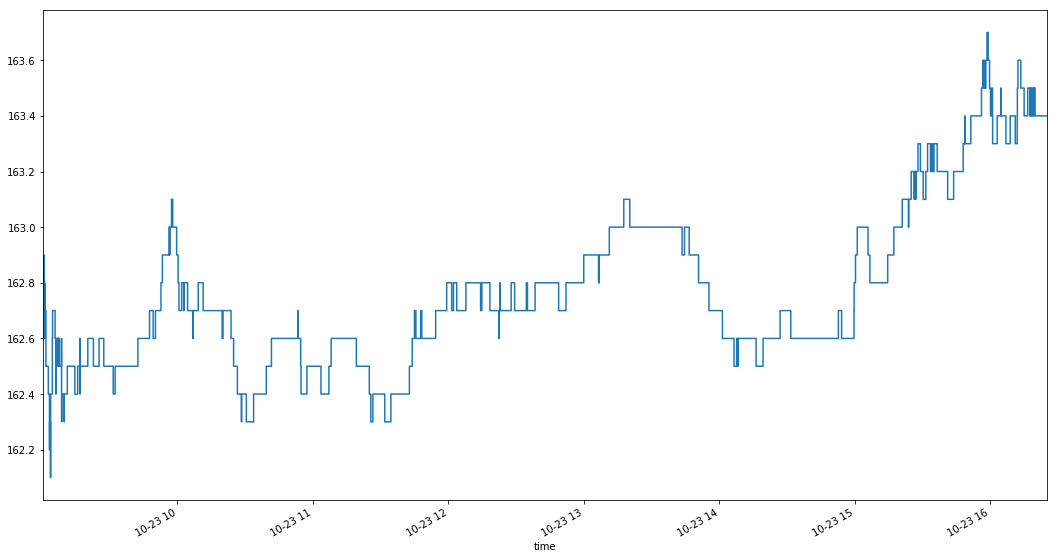

In [8]:
stl.trades.price.plot(drawstyle='steps')

## Resampling trade data
You can easily resample the trade data yourself using pandas resample, but dl.get_ohlcv() will make it easier. dl.get_ohlcv() takes two parameters:
- interval is the pandas resampling window ('30s', '2min', '1h' etc)
- vwap which will also resample the volume weighted average price from the trade data dataframe. 

Note that volume always is included.


In [9]:
ohlcv = stl.get_ohlcv(interval='5min')

dl.get_ohlcv() also returns a Pandas dataframe, hence all Pandas functionality is available as well.

In [10]:
ohlcv.tail()

,time,open,high,low,close,volume
time,,,,,,
2017-10-23 16:05:00,2017-10-23 16:05:00,163.4,163.4,163.3,163.3,8437.0
2017-10-23 16:10:00,2017-10-23 16:10:00,163.4,163.6,163.3,163.5,22926.0
2017-10-23 16:15:00,2017-10-23 16:15:00,163.5,163.5,163.4,163.5,18612.0
2017-10-23 16:20:00,2017-10-23 16:20:00,163.5,163.5,163.5,163.5,0.0
2017-10-23 16:25:00,2017-10-23 16:25:00,163.4,163.4,163.4,163.4,626843.0


## Plotting OHLC resampeled data
Matplotlib is not the very best plotting library for financial plots, so using a custom wrapper function borrowed from quantopian (not sure where). Here we also utilize Ta-lib to add some technical overlays.

In [11]:
def plot_candles(pricing, title=None,
                 volume_bars=False,
                 color_function=None,
                 overlays=None,
                 technicals=None,
                 technicals_titles=None):

    def default_color(index, open, close, low, high):
        return 'r' if open[index] > close[index] else 'g'
    color_function = color_function or default_color
    overlays = overlays or []
    technicals = technicals or []
    technicals_titles = technicals_titles or []
    open = pricing['open']
    close = pricing['close']
    low = pricing['low']
    high = pricing['high']
    oc_min = pd.concat([open, close], axis=1).min(axis=1)
    oc_max = pd.concat([open, close], axis=1).max(axis=1)
    
    subplot_count = 1
    if volume_bars:
        subplot_count = 2
    if technicals:
        subplot_count += len(technicals)
    
    if subplot_count == 1:
        fig, ax1 = plt.subplots(1, 1)
    else:
        ratios = np.insert(np.full(subplot_count - 1, 1), 0, 3)
        fig, subplots = plt.subplots(subplot_count, 1, sharex=True, gridspec_kw={'height_ratios': ratios})
        ax1 = subplots[0]
        
    if title:
        ax1.set_title(title)
    x = np.arange(len(pricing))
    candle_colors = [color_function(i, open, close, low, high) for i in x]
    candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
    lines = ax1.vlines(x, low, high, color=candle_colors, linewidth=1)
    ax1.xaxis.grid(False)
    ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
    # Assume minute frequency if first two bars are in the same day.
    frequency = 'minute' if (pricing.index[1] - pricing.index[0]).days == 0 else 'day'
    time_format = '%d-%m-%Y'
    if frequency == 'minute':
        time_format = '%H:%M'
    # Set X axis tick labels.
    plt.xticks(x, [date.strftime(time_format) for date in pricing.index], rotation='vertical')
    for overlay in overlays:
        ax1.plot(x, overlay)
    # Plot volume bars if needed
    if volume_bars:
        ax2 = subplots[1]
        volume = pricing['volume']
        volume_scale = None
        scaled_volume = volume
        if volume.max() > 1000000:
            volume_scale = 'M'
            scaled_volume = volume / 1000000
        elif volume.max() > 1000:
            volume_scale = 'K'
            scaled_volume = volume / 1000
        ax2.bar(x, scaled_volume, color=candle_colors)
        volume_title = 'Volume'
        if volume_scale:
            volume_title = 'Volume (%s)' % volume_scale
        ax2.set_title(volume_title)
        ax2.xaxis.grid(False)
    # Plot additional technical indicators
    for (i, technical) in enumerate(technicals):
        ax = subplots[i - len(technicals)] # Technical indicator plots are shown last
        ax.plot(x, technical)
        if i < len(technicals_titles):
            ax.set_title(technicals_titles[i])

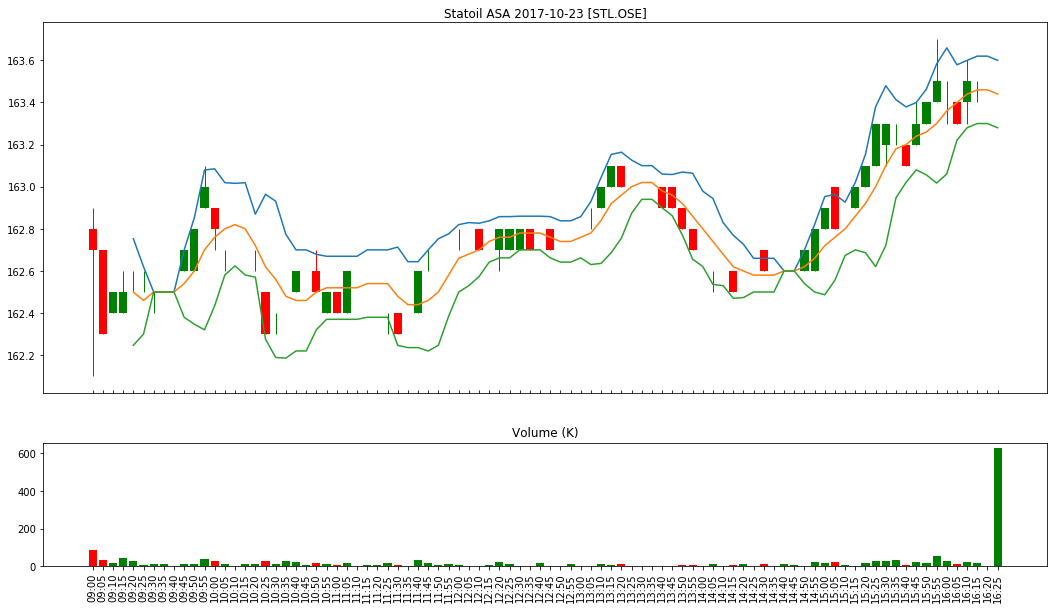

In [12]:
upper, middle, lower = talib.BBANDS(ohlcv['close'].as_matrix())
plot_candles(ohlcv, title='Statoil ASA 2017-10-23 [STL.OSE]',volume_bars=True, overlays=[upper, middle, lower])

### Plotting using Matplotlib's candlestick_ohlc

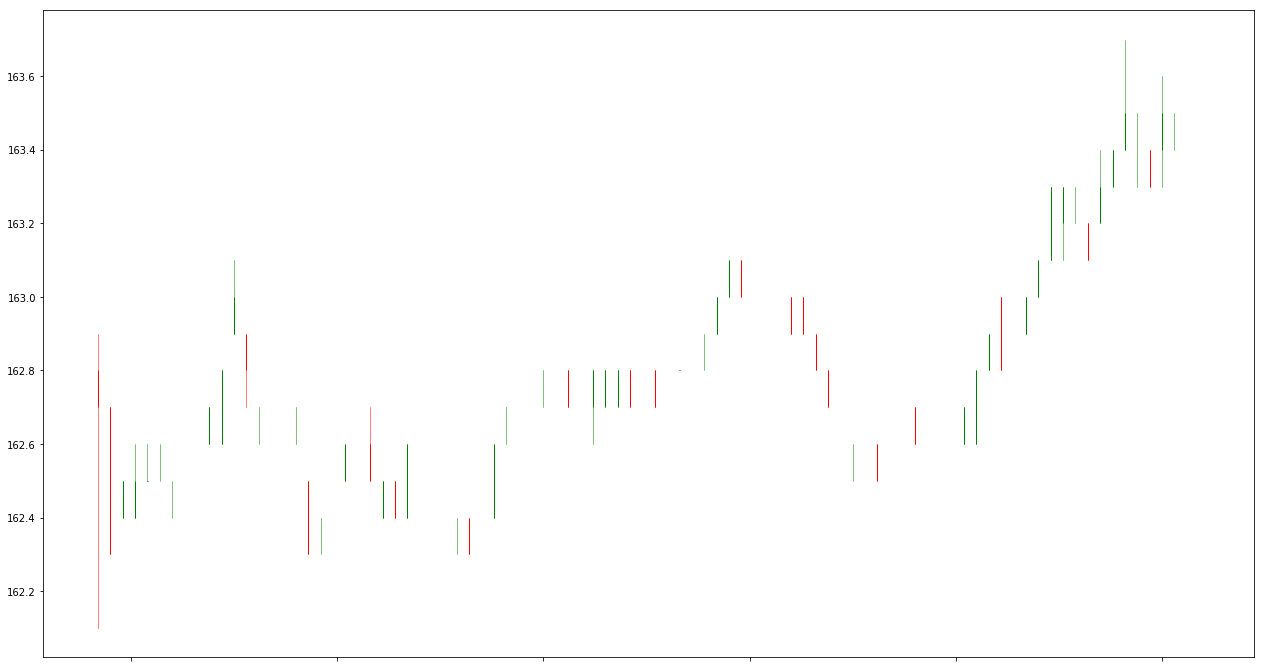

In [14]:
import matplotlib.ticker as mplticker
from matplotlib.dates import date2num
from matplotlib.finance import candlestick_ohlc

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(18,10))

ax.xaxis.set_major_locator(mplticker.MaxNLocator(6))

#Convert to integer, not date...
ohlcv['time'] = ohlcv.index.astype(np.int64) // 10**9
xdate = ohlcv['time'] #[datetime.fromtimestamp(i) for i in ohlc['time']]

def mydate(x,pos):
    try:
        return xdate[int(x)]
    except IndexError:
        return ''

ax.xaxis.set_major_formatter(mplticker.FuncFormatter(mydate))

fig.autofmt_xdate()
fig.tight_layout()

tuples = [tuple(x) for x in ohlcv[['time','open','high','low','close']].values]
candlestick_ohlc(ax, tuples, colorup='g')

plt.show()

## Accessing intraday positions (orderbook)
There is also a orderbook called positions available from Netfonds. It contains best bid and ask and a summary of total bid and ask.

In [15]:
positions = stl.get_positions()

In [16]:
positions.tail(5)

,time,bid,bid_depth,bid_depth_total,ask,ask_depth,ask_depth_total
time,,,,,,,
2017-10-23 16:25:21,2017-10-23 16:25:21,163.4,61597,883039,163.5,317,670032
2017-10-23 16:25:21,2017-10-23 16:25:21,163.4,60731,882173,163.5,317,670032
2017-10-23 16:25:21,2017-10-23 16:25:21,163.4,60316,881758,163.5,317,670032
2017-10-23 16:25:21,2017-10-23 16:25:21,163.4,59665,881107,163.5,317,670032
2017-10-23 16:25:21,2017-10-23 16:25:21,163.4,39762,861204,163.5,317,670032


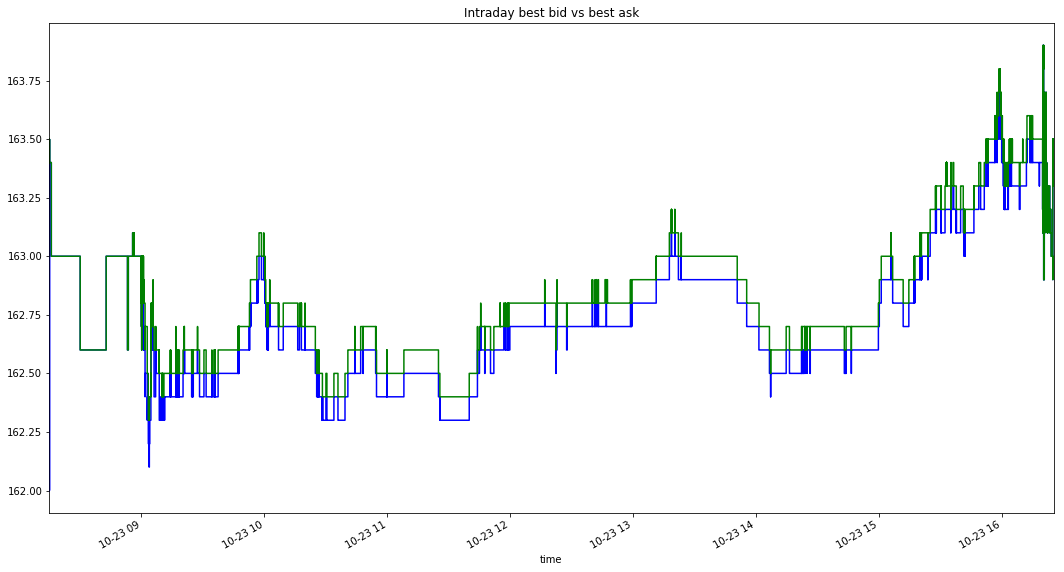

In [17]:
positions.bid.plot(drawstyle='steps', color='b')
positions.ask.plot(drawstyle='steps', color='g')
plt.title("Intraday best bid vs best ask")

## Getting broker statistics

In [18]:
brokers = stl.get_broker_stats()

In [19]:
brokers.tail()

,index,broker,sold,sold_trades,bought,bought_trades,total,positive
34,34,JPM,110285.0,133.0,58325.0,102.0,-51960.0,False
35,35,SGL,72883.0,118.0,16039.0,6.0,-56844.0,False
36,36,MSI,354811.0,447.0,290074.0,505.0,-64737.0,False
37,37,DNM,135715.0,106.0,35134.0,126.0,-100581.0,False
38,38,CSB,166323.0,640.0,63507.0,188.0,-102816.0,False


### Plotting brokers net sold/bought

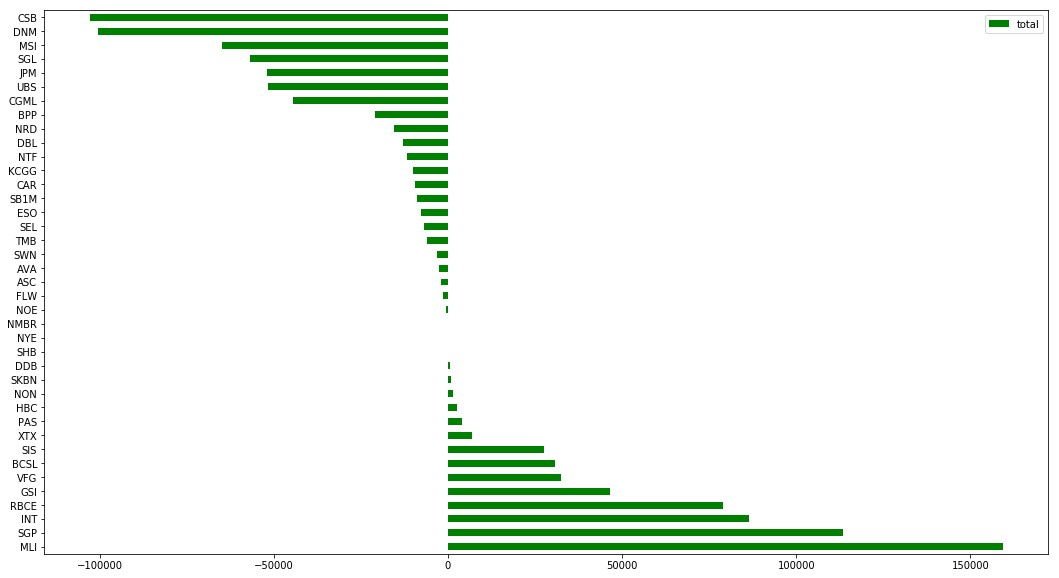

In [20]:
brokers['sold'] = -1*brokers['sold']
brokers[['total']].plot(kind='barh', color=brokers['positive'].map({True: 'g', False: 'r'}))
plt.yticks( range(brokers.total.count()), brokers.broker)
plt.show()

### Plotting sold and bought per broker

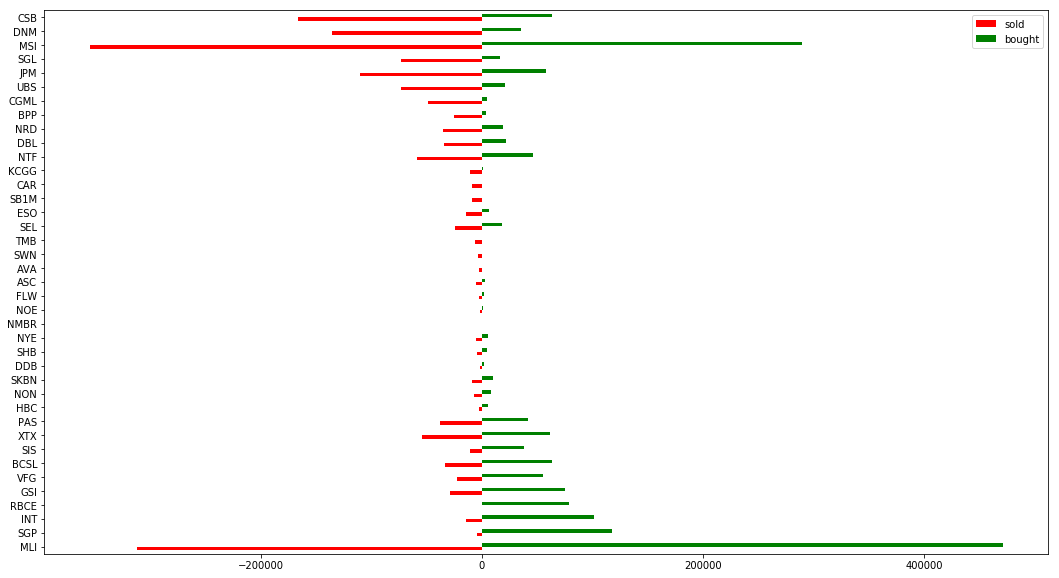

In [21]:
brokers[['sold', 'bought']].plot(kind='barh', color=['r', 'g'])
plt.yticks( range(brokers.total.count()), brokers.broker)
#ax1.text(0, 0, stock_sell_buy['broker'], horizontalalignment=align, verticalalignment='center', color=clr, weight='bold') 
plt.show()